In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
print(os.getcwd())#显示当前路径
 
os.chdir('D:/bio/metirc/scib-main')#更改路径，''里面为更改的路径

print(os.getcwd())#显示当前路径

os.environ['R_HOME'] = "E:/R/R-4.2.1/"
os.environ['R_USER'] = "D:/anaconda/envs/index/Lib/site-packages/rpy2"


import index

# import importlib
# importlib.reload(index)

import scib
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad 

def load_data_merge(file_paths, samples, verbose=True):
    adata_list = []
    for file_path in file_paths:
        adata_temp = sc.read_h5ad(file_path)
        if verbose:
            print(adata_temp)
        adata_temp.var_names_make_unique()
        adata_temp.obs_names_make_unique()
        adata_list.append(adata_temp)
    adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)
    return adata_pre

def load_data_merge2(file_paths, samples):
    adata_list = []
    for file_path in file_paths:
        adata_temp = sc.read_h5ad(file_path)
        adata_temp.var_names_make_unique()
        adata_temp.obs_names_make_unique()
        adata_list.append(adata_temp)
    adata_pre = ad.concat(adata_list)
    return adata_pre

def load_data_merge_mpfc(input_dir, samples):
    adata_list = []
    for sample in samples:
        adata_temp = sc.read_h5ad(input_dir + sample + '.h5ad')
        adata_temp = adata_temp[adata_temp.obs['ClusterName']!='NA']
        adata_temp.var_names_make_unique()
        adata_temp.obs_names_make_unique()
        adata_temp.obsm['spatial'] = adata_temp.obs[['x', 'y']].values
        if sample == 'BZ5':
            adata_temp.obs['z'] = adata_temp.obs['z'] + 1
            adata_temp.obs['z'] = adata_temp.obs['z'].astype('str')
        print(adata_temp.shape)
        adata_list.append(adata_temp)
    adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)
    return adata_pre

def load_data_mpfc(input_dir, samples):
    adata_list = []
    for sample in samples:
        adata_temp = sc.read_h5ad(input_dir + sample + '.h5ad')
        adata_temp = adata_temp[adata_temp.obs['ClusterName']!='NA']
        adata_temp.var_names_make_unique()
        adata_temp.obs_names_make_unique()
        adata_temp.obsm['spatial'] = adata_temp.obs[['x', 'y']].values
        if sample == 'BZ5':
            adata_temp.obs['z'] = adata_temp.obs['z'] + 1
            adata_temp.obs['z'] = adata_temp.obs['z'].astype('str')
        print(adata_temp.shape)
        adata_list.append(adata_temp)
    adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)
    return adata_pre
# samples = ['embryo1-2', 'embryo1-5', 'embryo2-2', 'embryo2-5', 'embryo3-2', 'embryo3-5']
# adata_pre = load_data_merge(['G:/dataset/07-seqFish-SpatialMouseAtlas/input/'+sample+'.h5ad' for sample in samples], samples)
# adata_pre.obsm['spatial'] = adata_pre.obs[['x_global','y_global']].values
# print(adata_pre)

# index

In [ ]:
def scs(adatas, annotation):
    ###SCC
    # source
    adatas.obsm['spatial'] = adatas.obsm['spatial_origin'].copy()
    knn = 6
    g, node_dict = index.generate_graph_from_labels(adatas, adatas.obs[annotation] ,knn)
    scs = index.spatial_coherence_score(g, node_dict, 100)
    adatas.uns['scc_origin'] = scs
    # align
    adatas.obsm['spatial'] = adatas.obsm['spatial_aligned'].copy()
    knn = 6
    g, node_dict = index.generate_graph_from_labels(adatas, adatas.obs[annotation] ,knn)
    scs = index.spatial_coherence_score(g, node_dict, 100)
    adatas.uns['scc_aligned'] = scs
    return adatas

In [ ]:
def Moran_Geary(adatas, input_path, samples):
    
    groups = adatas.obs.groupby("batch").indices
    adata_list = [adatas[i] for i in groups.values()]
    ###moran's I & geary's C
    for i in range(len(samples)):
        input_dir = input_path
        SVGs = pd.read_csv(input_dir + samples[i] + '_SPARKX.csv', index_col=0)
        SVGs.rename(index=lambda s: s.replace('.', '-'), inplace=True)
        SVGs_gene = list(set(SVGs.index.tolist()).intersection(set(adata_list[i].var_names.tolist())))
        SVGs = SVGs.loc[SVGs_gene]
        SVGs = SVGs.sort_values(by="adjustedPval",ascending=True)
        # source
        moranI_dict = {}
        gearyC_dict = {}
        sc.pp.neighbors(adata_list[i], use_rep='spatial_origin')
        num = [1,10,50,100,500,1000]
        for SVGnum in num:
            print(SVGnum)
            if SVGnum > SVGs.shape[0]:
                break
            moranI = np.mean( sc.metrics.morans_i(adata_list[i], vals = adata_list[i][:, SVGs.index.tolist()[:SVGnum]].X.toarray().T) )
            moranI_dict["moranI_"+str(SVGnum)] = moranI
            gearyC = np.mean( sc.metrics.gearys_c(adata_list[i], vals = adata_list[i][:, SVGs.index.tolist()[:SVGnum]].X.toarray().T) )
            gearyC_dict["gearyC_"+str(SVGnum)] = gearyC
        # align
        moranI_align_dict = {}
        gearyC_align_dict = {}
        sc.pp.neighbors(adata_list[i], use_rep='spatial_aligned')
        num = [1,10,50,100,500,1000]
        for SVGnum in num:
            print(SVGnum)
            if SVGnum > SVGs.shape[0]:
                break
            moranI = np.mean( sc.metrics.morans_i(adata_list[i], vals = adata_list[i][:, SVGs.index.tolist()[:SVGnum]].X.toarray().T) )
            moranI_align_dict["moranI_"+str(SVGnum)] = moranI
            gearyC = np.mean( sc.metrics.gearys_c(adata_list[i], vals = adata_list[i][:, SVGs.index.tolist()[:SVGnum]].X.toarray().T) )
            gearyC_align_dict["gearyC_"+str(SVGnum)] = gearyC
        
        print(samples[i])
        print(moranI_dict)
        print(moranI_align_dict)
        print(gearyC_dict)
        print(gearyC_align_dict)

In [ ]:
import scipy
def SSIM_PCC(adatas, annotation):
    groups = adatas.obs.groupby("batch").indices
    adata_list = [adatas[i] for i in groups.values()]
    ### SSIM & PCC
    for i in range(len(adata_list)):
        adata_list[i].obsm['spatial_aligned'] = pd.DataFrame(adata_list[i].obsm['spatial_aligned'], index=adata_list[i].obs_names)
        adata_list[i].obsm['spatial_aligned'].columns = ['X', 'Y']
    # each slice is rasterized on the overlap of the previous slice
    for i in range(1, len(adata_list)):
        x_max = np.ceil(np.min([adata_list[i].obsm['spatial_aligned'].max().X, adata_list[i - 1].obsm['spatial_aligned'].max().X]))
        y_max = np.ceil(np.min([adata_list[i].obsm['spatial_aligned'].max().Y, adata_list[i - 1].obsm['spatial_aligned'].max().Y]))
        x_min = np.floor(np.max([adata_list[i].obsm['spatial_aligned'].min().X, adata_list[i - 1].obsm['spatial_aligned'].min().X]))
        y_min = np.floor(np.max([adata_list[i].obsm['spatial_aligned'].min().Y, adata_list[i - 1].obsm['spatial_aligned'].min().Y]))
        adata_list[i].uns['grid_prop_withbefore'] = index.cal_grid_prop(adata_list[i], spatial_key='spatial_aligned', celltype_key=annotation,
                                                             grid_max=[x_max, y_max], grid_min=[x_min, y_min])
    # each slice is rasterized on the overlap of the next slice
    for i in range(0, len(adata_list)-1):
        x_max = np.ceil(np.min([adata_list[i].obsm['spatial_aligned'].max().X, adata_list[i + 1].obsm['spatial_aligned'].max().X]))
        y_max = np.ceil(np.min([adata_list[i].obsm['spatial_aligned'].max().Y, adata_list[i + 1].obsm['spatial_aligned'].max().Y]))
        x_min = np.floor(np.max([adata_list[i].obsm['spatial_aligned'].min().X, adata_list[i + 1].obsm['spatial_aligned'].min().X]))
        y_min = np.floor(np.max([adata_list[i].obsm['spatial_aligned'].min().Y, adata_list[i + 1].obsm['spatial_aligned'].min().Y]))
        adata_list[i].uns['grid_prop_withnext'] = index.cal_grid_prop(adata_list[i], spatial_key='spatial_aligned', celltype_key=annotation,
                                                           grid_max=[x_max, y_max], grid_min=[x_min, y_min])
    # calculate SSIM on the overlap of each two adjacent slices
    for i in range(1, len(adata_list)):
        grid_a = adata_list[i].uns['grid_prop_withbefore'].copy()
        grid_b = adata_list[i - 1].uns['grid_prop_withnext'].copy()
        col = set(grid_a.columns) & set(grid_b.columns)
        grid_a = grid_a.loc[:, col]
        grid_b = grid_b.loc[:, col]
        ssim_list = []
        for n in range(grid_a.shape[0]):
            ssim_list.append(index.ssim(grid_a.iloc[n, :].values, grid_b.iloc[n, :].values))
        ssim_list = np.array(ssim_list)
        ssim_list[grid_b.sum(1) == 0] = np.inf
        ssim_list[pd.isna(pd.Series(ssim_list))] = 0
        adata_list[i].uns['ssim'] = ssim_list
    ssim_compare = []
    for i in range(1, len(adata_list)):
        ssim_compare.append([adata_list[i].uns['ssim'][adata_list[i].uns['ssim'] != np.inf].mean(), i, method])
    ssim_compare = pd.DataFrame(ssim_compare).fillna(0)
    ssim_compare.columns = ['ssim', 'slice', 'method']
    print(ssim_compare)
    
    # calculate PCC on the overlap of each two adjacent slices
    for i in range(1, len(adata_list)):
        grid_a = adata_list[i].uns['grid_prop_withbefore'].copy()
        grid_b = adata_list[i - 1].uns['grid_prop_withnext'].copy()
        col = set(grid_a.columns) & set(grid_b.columns)
        grid_a = grid_a.loc[:, col]
        grid_b = grid_b.loc[:, col]
        pcc_list = []
        for n in range(grid_a.shape[0]):
            pcc_list.append(scipy.stats.pearsonr(grid_a.iloc[n, :].values, grid_b.iloc[n, :].values)[0])
        pcc_list = np.array(pcc_list)
        pcc_list[grid_b.sum(1) == 0] = np.inf
        pcc_list[pd.isna(pd.Series(pcc_list))] = 0
        adata_list[i].uns['pcc'] = pcc_list
    pcc_compare = []
    for i in range(1, len(adata_list)):
        pcc_compare.append([adata_list[i].uns['pcc'][adata_list[i].uns['pcc'] != np.inf].mean(), i, method])
    pcc_compare = pd.DataFrame(pcc_compare).fillna(0)
    pcc_compare.columns = ['pcc', 'slice', 'method']
    print(pcc_compare)

In [16]:
input_dir = 'G:/dataset/12-sim/3batch_5celltype_align/'
output_dir = input_dir
adata_pre = sc.read_h5ad(input_dir + 'align_3batch_5celltype.h5ad')
annotation = 'celltype'
adata_pre

AnnData object with n_obs × n_vars = 1200 × 500
    obs: 'Unnamed: 0', 'x', 'y', 'celltype', 'batch'
    uns: 'batch_colors', 'celltype_colors', 'neighbors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

AnnData object with n_obs × n_vars = 1200 × 292
    obs: 'Unnamed: 0', 'x', 'y', 'celltype', 'batch', 'n_counts'
    var: 'n_counts'
    uns: 'batch_colors', 'celltype_colors', 'neighbors', 'tsne', 'umap', 'scc_origin', 'scc_aligned'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'spatial', 'spatial_aligned', 'spatial_origin'
    obsp: 'connectivities', 'distances'
['Cell5', 'Cell14', 'Cell16', 'Cell26', 'Cell28']
          Unnamed: 0   x   y   celltype   batch     n_counts
cell                                                        
Cell5              1   1   1  celltype1  batch1   985.871930
Cell14             2   1   2  celltype1  batch1   985.912932
Cell16             3   1   3  celltype1  batch1   998.994274
Cell26             4   1   4  celltype1  batch1   971.557283
Cell28             5   1   5  celltype1  batch1   981.895347
...              ...  ..  ..        ...     ...          ...
Cell1373        1196  20  16  celltype5  batch3  1001.289985
Cell1377        1197  20  17  celltype5  

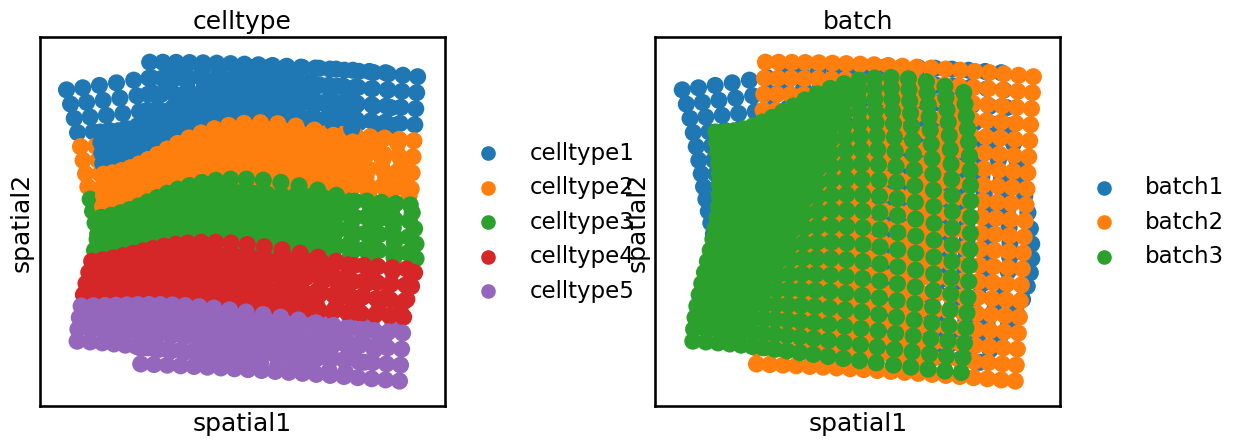

In [28]:
method = 'SPIRAL'
# adata_pre = load_data_mpfc(input_dir, samples)
# adata_pre.obsm['spatial'] = adata_pre.obsm['spatial'].astype('float')
adata_pre.obs[annotation] = adata_pre.obs[annotation].astype("category")
adata_pre.obs['batch'] = adata_pre.obs['batch'].astype('category')
coord_csv = output_dir + method + '.csv'
print(adata_pre)
print(adata_pre.obs_names.tolist()[:5])
if method == 'STUtility':
    STUtility_coor_pd = pd.read_csv(coord_csv, sep=" ")
    print(STUtility_coor_pd.shape)
    print(STUtility_coor_pd.head())
    if adata_pre.shape[0] != STUtility_coor_pd.shape[0]:
        STUtility_coor_pd.rename(index=lambda s: s.split('_',1)[0] + '-' + samples[int(s.split('_',1)[1])-1], inplace=True)
        adatas = adata_pre[STUtility_coor_pd.index.tolist(), :]
    else:
        adatas = adata_pre
    assert adatas.shape[0] == STUtility_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = STUtility_coor_pd[["align_x" , "align_y" ]].values
    adatas.obsm['spatial_origin'] = STUtility_coor_pd[['x', 'y']].values
if method == 'moscot_affine':
    moscot_coor_pd = pd.read_csv(coord_csv, index_col=0)
    print(moscot_coor_pd.shape)
    print(moscot_coor_pd.head())
    adatas = adata_pre
    assert adatas.shape[0] == moscot_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = moscot_coor_pd.values
    adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
if method == 'moscot_warp':
    moscot_coor_pd = pd.read_csv(coord_csv, index_col=0)
    adatas = adata_pre
    assert adatas.shape[0] == moscot_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = moscot_coor_pd.values
    adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
if method == 'STalign':
#     adata_list = []
#     for sample in samples:
#         adata_temp = sc.read_h5ad(input_dir+sample+'.h5ad')
#         adata_temp = adata_temp[adata_temp.obs['ClusterName']!='NA']
#         adata_temp.obsm['spatial'] = adata_temp.obs[['x', 'y']].values
#         adata_temp.var_names_make_unique()
#         adata_temp.obs_names_make_unique()
#         if sample == 'BZ5':
#             adata_temp.obs['z'] = adata_temp.obs['z'] + 1
#             adata_temp.obs['z'] = adata_temp.obs['z'].astype('str')
#         if sample != samples[-1]:
#             i = samples.index(sample)
#             STalign_coor_pd = pd.read_csv(output_dir + samples[i] +"_aligned_to_" + samples[i+1] + ".csv", index_col=0)
#             print(STalign_coor_pd.shape)
#             adata_temp.obsm['spatial_origin'] = adata_temp.obsm['spatial'].copy()
#             adata_temp.obsm['spatial_aligned'] = STalign_coor_pd[['aligned_x', 'aligned_y']].values
#         else:
#             adata_temp.obsm['spatial_origin'] = adata_temp.obsm['spatial'].copy()
#             adata_temp.obsm['spatial_aligned'] = adata_temp.obsm['spatial'].copy()
#         adata_list.append(adata_temp)
#     adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)
#     adata_pre.obs[annotation] = adata_pre.obs[annotation].astype("category")
#     adata_pre.obs['batch'] = adata_pre.obs['batch'].astype('category')
#     adata_pre.obsm['spatial'] = adata_pre.obsm['spatial'].astype(float)
#     adatas = adata_pre
#     del adata_list
#     del adata_temp
    adata_list = []
    for sample in samples:
        adata_temp = sc.read_h5ad(input_dir + 'merfish_mouse_brain_slice' + sample + '.h5ad')
        adata_temp.obs['batch'] = sample
#             adata_temp = adata_temp[adata_temp.obs['ClusterName']!='NA']
        adata_temp.obsm['spatial'] = adata_temp.obsm['spatial'][['X', 'Y']].values
        adata_temp.var_names_make_unique()
        adata_temp.obs_names_make_unique()
        if sample != samples[0]:
            i = samples.index(sample)
            STalign_coor_pd = pd.read_csv(output_dir + samples[i] +"_aligned_to_" + samples[i-1] + ".csv", index_col=0)
            print(STalign_coor_pd.shape)
            adata_temp.obsm['spatial_origin'] = adata_temp.obsm['spatial'].copy()
            adata_temp.obsm['spatial_aligned'] = STalign_coor_pd[['aligned_x', 'aligned_y']].values
        else:
            adata_temp.obsm['spatial_origin'] = adata_temp.obsm['spatial'].copy()
            adata_temp.obsm['spatial_aligned'] = adata_temp.obsm['spatial'].copy()
        adata_list.append(adata_temp)
    adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)
    adata_pre.obs[annotation] = adata_pre.obs[annotation].astype("category")
    adata_pre.obs['batch'] = adata_pre.obs['batch'].astype('category')
    adata_pre.obsm['spatial'] = adata_pre.obsm['spatial'].astype(float)
    adatas = adata_pre
    del adata_list
    del adata_temp
if method == 'paste':
    sc.pp.filter_genes(adata_pre, min_counts = 15)
    sc.pp.filter_cells(adata_pre, min_counts = 100)
    paste_coor_pd = pd.read_csv(coord_csv, index_col=0)
    print(paste_coor_pd.shape)
    print(paste_coor_pd.head())
    adatas = adata_pre
    assert adatas.shape[0] == paste_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = paste_coor_pd.values
    adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
if method == 'SPACEL':
    SPACEL_coor_pd = pd.read_csv(coord_csv, index_col=0)
# #     SPACEL_coor_pd.rename(index=lambda s: s.split('_',1)[0] + '-' + samples[int(s.split('_',1)[1])-1], inplace=True)
#     print(SPACEL_coor_pd.shape)
#     print(SPACEL_coor_pd.head())
    adatas = adata_pre
    assert adatas.shape[0] == SPACEL_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = SPACEL_coor_pd.values
    adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
    

if method == 'SPIRAL':
    SPIRAL_coor_pd = pd.read_csv(coord_csv, index_col=0)
    print(adata_pre.obs)
    print(SPIRAL_coor_pd.shape)
    print(SPIRAL_coor_pd.head(-5))
#     SPIRAL_coor_pd.rename(index=lambda s: s.split('-',1)[1] + '-' + s.split('-',1)[0], inplace=True)
#     SPIRAL_coor_pd.rename(index=lambda s: s.replace('.', '-'), inplace=True)
    adata_pre.obs['aligned_x'] = SPIRAL_coor_pd['x']
    adata_pre.obs['aligned_y'] = SPIRAL_coor_pd['y']
    adatas = adata_pre
    assert adatas.shape[0] == SPIRAL_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = adata_pre.obs[['aligned_y', 'aligned_x']].values
#     adatas.obsm['spatial_aligned'] = SPIRAL_coor_pd[['y', 'x']].values
    adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()


adatas.obsm['spatial_origin'] = adatas.obsm['spatial_origin'].astype('float')
adatas.obsm['spatial_aligned'] = adatas.obsm['spatial_aligned'].astype('float')
print(adatas)

sc.pl.spatial(adatas, color =[annotation, 'batch'], spot_size =0.2)

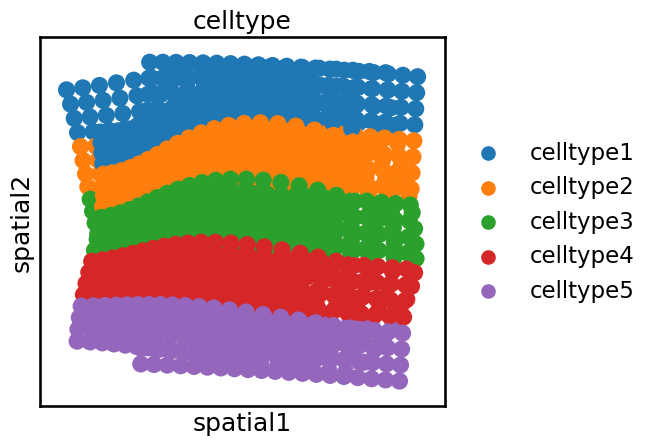

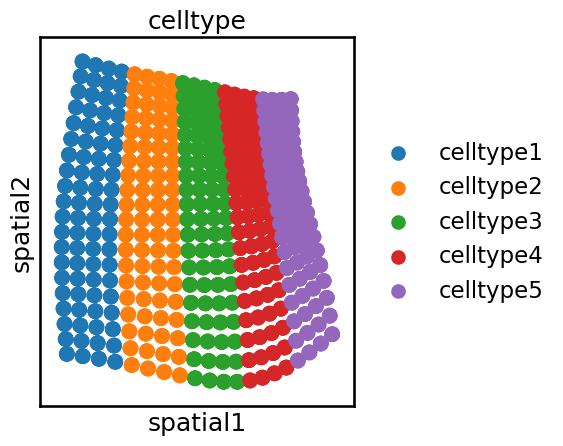

   ssim  slice  method
0   1.0      1  SPIRAL
1   1.0      2  SPIRAL
   pcc  slice  method
0  1.0      1  SPIRAL
1  1.0      2  SPIRAL
1
10
50
100
500
1
10
50
100
500
batch1
{'moranI_1': 0.7257420367392238, 'moranI_10': 0.5461753527812613, 'moranI_50': 0.4977827491493623, 'moranI_100': 0.43293926195200116}
{'moranI_1': 0.7257421146709618, 'moranI_10': 0.5461753749672907, 'moranI_50': 0.49778277329675163, 'moranI_100': 0.4329392800472872}
{'gearyC_1': 0.29613055199565796, 'gearyC_10': 0.45046576032629, 'gearyC_50': 0.5010731157394922, 'gearyC_100': 0.5663662450018145}
{'gearyC_1': 0.2961305690003633, 'gearyC_10': 0.45046577569186425, 'gearyC_50': 0.5010731331071046, 'gearyC_100': 0.5663662501782766}
1
10
50
100
500
1
10
50
100
500
batch2
{'moranI_1': 0.7133733270553082, 'moranI_10': 0.7842478732323768, 'moranI_50': 0.5307613013063798, 'moranI_100': 0.4240133363118091}
{'moranI_1': 0.7046461170975492, 'moranI_10': 0.7632468896147702, 'moranI_50': 0.5089540129923544, 'moranI_100': 0.40752

In [29]:
import warnings
warnings.filterwarnings("ignore")

adatas.obsm['spatial'] = adatas.obsm['spatial_origin']
sc.pl.spatial(adatas, color = annotation, spot_size =0.2)
adatas.obsm['spatial'] = adatas.obsm['spatial_aligned']
sc.pl.spatial(adatas, color = annotation, spot_size =0.2)
adatas
SSIM_PCC(adatas, annotation)
Moran_Geary(adatas, input_dir, ['batch1', 'batch2', 'batch3'])

In [30]:
scs(adatas, annotation)
print(adatas.uns['scc_origin'])
print(adatas.uns['scc_aligned'])

1.9827571283500207
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1.923908826406847
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
-143.13050988869185
-1725.1598750481387


In [ ]:
samples = ['embryo1-2', 'embryo1-5']
input_dir = 'G:/dataset/07-seqFish-SpatialMouseAtlas/input/'
output_dir ='G:/dataset/07-seqFish-SpatialMouseAtlas/output/result/embryo1/spatial/'

method = 'STUtility'

if method == 'STUtility':
    adata_pre = load_data_merge([input_dir+sample+'.h5ad' for sample in samples], samples)
    print(adata_pre)
    print(adata_pre.obs_names.tolist()[:5])
    STUtility_coor_pd = pd.read_csv(output_dir + method + ".csv", sep=" ")
    print(STUtility_coor_pd.shape)
    print(STUtility_coor_pd.head())
    if adata_pre.shape[0] != STUtility_coor_pd.shape[0]:
        STUtility_coor_pd.rename(index=lambda s: s.split('_',1)[0] + '-' + samples[int(s.split('_',1)[1])-1], inplace=True)
        adatas = adata_pre[STUtility_coor_pd.index.tolist(), :]
    else:
        adatas = adata_pre
    assert adatas.shape[0] == STUtility_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = STUtility_coor_pd[["align_x" , "align_y" ]].values
    adatas.obsm['spatial_origin'] = STUtility_coor_pd[['x', 'y']].values
    print(adatas)

In [ ]:
samples = ['embryo2-2', 'embryo2-5']
input_dir = 'G:/dataset/07-seqFish-SpatialMouseAtlas/input/'
output_dir ='G:/dataset/07-seqFish-SpatialMouseAtlas/output/result/embryo2/spatial/'

method = 'moscot_warp'

if method == 'moscot_affine':
    adata_pre = load_data_merge([input_dir+'/'+sample+'.h5ad' for sample in samples], samples)
    adata_pre.obsm['spatial'] = adata_pre.obs[['x_global','y_global']].values
    print(adata_pre)
    print(adata_pre.obs_names.tolist()[:5])
    moscot_coor_pd = pd.read_csv(output_dir + method + ".csv", index_col=0)
    print(moscot_coor_pd.shape)
    print(moscot_coor_pd.head())
    adatas = adata_pre
    assert adatas.shape[0] == moscot_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = moscot_coor_pd.values
    adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
if method == 'moscot_warp':
    adata_pre = load_data_merge([input_dir+'/'+sample+'.h5ad' for sample in samples], samples)
    adata_pre.obsm['spatial'] = adata_pre.obs[['x_global','y_global']].values
    moscot_coor_pd = pd.read_csv(output_dir + method + ".csv", index_col=0)
    print(moscot_coor_pd.head())
    adatas = adata_pre
    assert adatas.shape[0] == moscot_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = moscot_coor_pd.values
    adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
# sc.pl.spatial(adatas, color = 'celltype_mapped_refined', spot_size =1)

In [ ]:
method = 'STalign'

if method == 'STalign':
    adata_list = []
    for sample in samples:
        adata_temp = sc.read_h5ad(input_dir+'/'+sample+'.h5ad')
        adata_temp.obsm['spatial'] = adata_temp.obs[['x_global','y_global']].values
        adata_temp.obsm['spatial'] = adata_temp.obsm['spatial'].astype('float')
        adata_temp.var_names_make_unique()
        adata_temp.obs_names_make_unique()
        if sample != samples[-1]:
            i = samples.index(sample)
            STalign_coor_pd = pd.read_csv(output_dir + samples[i] +"_aligned_to_" + samples[i+1] + ".csv", index_col=1)
            print(STalign_coor_pd.shape)
            print(STalign_coor_pd)
            adata_temp.obs['x'] = STalign_coor_pd['aligned_x']
            adata_temp.obs['y'] = STalign_coor_pd['aligned_y']
            adata_temp.obsm['spatial_origin'] = adata_temp.obsm['spatial'].copy()
            adata_temp.obsm['spatial_aligned'] = adata_temp.obs[['x', 'y']].values
        else:
            adata_temp.obsm['spatial_origin'] = adata_temp.obsm['spatial'].copy()
            adata_temp.obsm['spatial_aligned'] = adata_temp.obsm['spatial'].copy()
        adata_temp.obsm['spatial'] = adata_temp.obsm['spatial_aligned']
        sc.pl.spatial(adata_temp, color = 'celltype_mapped_refined', spot_size =1)
        adata_list.append(adata_temp)
    adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)
    adatas = adata_pre
    del adata_list
    del adata_temp


In [ ]:
method = 'paste'

if method == 'paste':
    adata_pre = load_data_merge2([input_dir+sample+'.h5ad' for sample in samples], samples)
    adata_pre.obsm['spatial'] = adata_pre.obs[['x_global','y_global']].values
    sc.pp.filter_genes(adata_pre, min_counts = 15)
    sc.pp.filter_cells(adata_pre, min_counts = 100)
#     adata_pre.obsm['spatial'] = adata_pre.obs[['x', 'y']].values
    print(adata_pre)
    print(adata_pre.obs_names.tolist()[:5])
    print(adata_pre.obs_names.tolist()[-5:])
    
    paste_coor_pd = pd.read_csv(output_dir + method + ".csv", index_col=0)
#     paste_coor_pd.rename(index=lambda s: s.split('_',1)[0] + '-' + samples[int(s.split('_',1)[1])-1], inplace=True)
#     paste_coor_pd.index = paste_coor_pd_index
    print(paste_coor_pd.shape)
    print(paste_coor_pd.head())
    adatas = adata_pre[paste_coor_pd.index.tolist(), :]
#     adatas = adata_pre
    assert adatas.shape[0] == paste_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = paste_coor_pd[['x','y']].values
    adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
    
sc.pl.spatial(adatas, color = 'celltype_mapped_refined', spot_size =1)

In [ ]:
method = 'SPACEL'
if method == 'SPACEL':    
    adata_pre = load_data_merge([input_dir+sample+'.h5ad' for sample in samples], samples)
    adata_pre.obsm['spatial'] = adata_pre.obs[['x_global','y_global']].values
    print(adata_pre)
    print(adata_pre.obs_names.tolist()[:5])
    print(adata_pre.obs_names.tolist()[-5:])
    
    SPACEL_coor_pd = pd.read_csv(output_dir + method + ".csv", index_col=0)
#     SPACEL_coor_pd.rename(index=lambda s: s.split('_',1)[0] + '-' + samples[int(s.split('_',1)[1])-1], inplace=True)
    print(SPACEL_coor_pd.shape)
    print(SPACEL_coor_pd.head())
    adatas = adata_pre
    assert adatas.shape[0] == SPACEL_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = SPACEL_coor_pd.values
    adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()


In [ ]:
method = 'SPIRAL'
if method == 'SPIRAL':
    adata_pre = load_data_merge([input_dir+sample+'.h5ad' for sample in samples], samples)
    print(adata_pre)
    adata_pre.obsm['spatial'] = adata_pre.obsm['spatial'] = adata_pre.obs[['x_global','y_global']].values
    print(adata_pre)
    print(adata_pre.obs_names.tolist()[:5])
    print(adata_pre.obs_names.tolist()[-5:])
    SPIRAL_coor_pd = pd.read_csv(output_dir + method + ".csv", index_col=0)
    
    adata_pre.obs['x'] = STalign_coor_pd['aligned_x']
    adata_pre.obs['y'] = STalign_coor_pd['aligned_y']
    print(SPIRAL_coor_pd.shape)
    print(SPIRAL_coor_pd.head())
#     SPIRAL_coor_pd.rename(index=lambda s: s.split('-',1)[1] + '-' + s.split('-',1)[0], inplace=True)
    adatas = adata_pre
    assert adatas.shape[0] == SPIRAL_coor_pd.shape[0],"check shape"
    adatas.obsm['spatial_aligned'] = adata_pre.obs[['x','y']].values
    adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
    print(adatas)

# all in a code

In [ ]:
import os
print(os.getcwd())#显示当前路径
 
os.chdir('D:/bio/metirc/scib-main')#更改路径，''里面为更改的路径

print(os.getcwd())#显示当前路径

os.environ['R_HOME'] = "E:/R/R-4.2.1/"
os.environ['R_USER'] = "D:/anaconda/envs/index/Lib/site-packages/rpy2"


import index

# import importlib
# importlib.reload(index)

import scib
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad 

import scipy

def load_data_merge(file_paths, samples):
    adata_list = []
    for file_path in file_paths:
        adata_temp = sc.read_h5ad(file_path)
        adata_list.append(adata_temp)
    adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)
    return adata_pre

def load_data(file_paths):
    adata_list = []
    for file_path in file_paths:
        adata_list.append(adata_temp)
    return adata_list


# methods = ['STUtility', 'moscot_affine', 'moscot_warp', 'STalign', 'paste', 'SPACEL', 'SPIRAL']
methods = ['moscot_affine']

for method in methods:
    print(method)
    annotation = 'celltype_mapped_refined'
    samples = ['embryo3-2', 'embryo3-5']
    input_dir = 'G:/dataset/07-seqFish-SpatialMouseAtlas/input/'
    output_dir ='G:/dataset/07-seqFish-SpatialMouseAtlas/output/result/embryo3/spatial/'
    if method == 'STUtility':
        adata_pre = load_data_merge([input_dir+sample+'/'+sample+'.h5ad' for sample in samples], samples)
        STUtility_coor_pd = pd.read_csv(input_dir+"STUtility_coord.csv")
#         STUtility_coor_pd.rename(index=lambda s: s.split('_',1)[0] + '-' + str(int(s.split('_',1)[1]) + 151672), inplace=True)
        adatas = adata_pre[STUtility_coor_pd.index.tolist(), :]
        assert adata_pre.shape[0] == STUtility_coor_pd.shape[0],"check shape"
        adatas.obsm['spatial_aligned'] = STUtility_coor_pd[['align_x', 'align_y']].values
        adatas.obsm['spatial_origin'] = STUtility_coor_pd[['x', 'y']].values
    if method == 'moscot_affine':
        adata_pre = load_data_merge([input_dir+sample+'/'+sample+'.h5ad' for sample in samples], samples)
        moscot_coor_pd = pd.read_csv(input_dir+"moscot_affine.csv", header = None)
        adatas = adata_pre
        adatas.obsm['spatial_aligned'] = moscot_coor_pd.values
        adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
    if method == 'moscot_warp':
        adata_pre = load_data_merge([input_dir+sample+'/'+sample+'.h5ad' for sample in samples], samples)
        moscot_coor_pd = pd.read_csv(input_dir+"moscot_warp.csv", header = None)
        adatas = adata_pre
        adatas.obsm['spatial_aligned'] = moscot_coor_pd.values
        adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
    if method == 'STalign':
        adata_list = []
        for i in range(len(samples)):
            input_dir = 'G:/dataset/1_DLPFC/input/'+samples[i]+'/'
            adata_temp = sc.read_visium(input_dir)
            adata_temp.var_names_make_unique()
            adata_temp.obs_names_make_unique()
            adata_label = pd.read_csv(input_dir + 'truth.csv', index_col=0)
            adata_temp.obs['batch'] = adata_label['batch'].astype("category")
            adata_temp.obs[annotation] = adata_label[annotation].astype("category")
            if i != (len(samples)-1):
                STalign_coor_pd = pd.read_csv('G:/dataset/1_DLPFC/output/STalign/'+samples[i]+'_aligned_to_'+samples[i+1]+'.csv')
                STalign_coor_pd.index = STalign_coor_pd['0']
                df = pd.merge(adata_temp.obs,STalign_coor_pd,how='inner',left_index=True,right_index=True)
                adata_temp.obsm['spatial_origin'] = adata_temp.obsm['spatial'].copy()
                adata_temp.obsm['spatial_aligned'] = df[['aligned_y', 'aligned_x']].values
                print(adata_temp.obsm['spatial_origin'][:5])
                print(adata_temp.obsm['spatial_aligned'][:5])
            else:
                adata_temp.obsm['spatial_origin'] = adata_temp.obsm['spatial'].copy()
                adata_temp.obsm['spatial_aligned'] = adata_temp.obsm['spatial'].copy()
            adata_list.append(adata_temp)
        adata_pre = ad.concat(adata_list, index_unique="-", keys = samples)
        adatas = adata_pre
        del adata_list
        del adata_temp
    if method == 'paste':
        adata_list = []
        for i in range(151673,151677):
            input_dir = 'G:/dataset/1_DLPFC/input/'+str(i)+'/'
            adata_temp = sc.read_visium(input_dir)
            adata_temp.var_names_make_unique()
            adata_temp.obs_names_make_unique()
            adata_label = pd.read_csv(input_dir + 'truth.csv', index_col=0)
            adata_temp.obs['batch'] = adata_label['batch'].astype("category")
            adata_temp.obs['ground.truth'] = adata_label['ground.truth'].astype("category")
            paste_coor_pd = pd.read_csv('G:/dataset/1_DLPFC/output/PASTE/'+str(i)+'.csv')
            paste_coor_pd.index = paste_coor_pd['spot']
            paste_coor_pd.rename(index=lambda s: s.split('.',1)[0], inplace=True)
            adata_temp = adata_temp[paste_coor_pd.index.tolist(), :]
            adata_temp.obsm['spatial_origin'] = adata_temp.obsm['spatial'].copy()
            adata_temp.obsm['spatial_aligned'] = paste_coor_pd[['aligned_x', 'aligned_y']].values
            adata_list.append(adata_temp)
        adata_pre = ad.concat(adata_list, index_unique="-", keys = [i for i in range(151673,151677)])
        print(adata_pre)
        adatas = adata_pre
        del adata_temp
        del adata_list
    if method == 'SPACEL':
        adata_pre = load_data(151673, 151677)
        SPACEL_coor_pd = pd.read_csv("G:/dataset/1_DLPFC/output/SPACEL/donor3_aligned_coordinates.csv")
        adatas = adata_pre
        adatas.obsm['spatial_aligned'] = SPACEL_coor_pd[['X','Y']].values
        adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
    if method == 'SPIRAL':
        adata_pre = load_data_merge([input_dir+sample+'.h5ad' for sample in samples], samples)
        adata_pre.obsm['spatial'] = adata_pre.obs[['x_global','y_global']].values
        SPIRAL_coor_pd = pd.read_csv(output_dir + method + ".csv", index_col=0)
#         SPIRAL_coor_pd.rename(index=lambda s: s.split('-',1)[1] + '-' + s.split('-',1)[0], inplace=True)
#         adatas = adata_pre[SPIRAL_coor_pd.index.tolist(), :]
        adatas = adata_pre
        assert adatas.shape[0] == SPIRAL_coor_pd.shape[0],"check shape"
        adatas.obsm['spatial_aligned'] = SPIRAL_coor_pd[['x', 'y']].values
        adatas.obsm['spatial_origin'] = adatas.obsm['spatial'].copy()
        adatas = adata_pre
        
    ###SCC
    # source
    adatas.obsm['spatial'] = adatas.obsm['spatial_origin'].copy()
    knn = 6
    g, node_dict = index.generate_graph_from_labels(adatas, adatas.obs[annotation] ,knn)
    scs = index.spatial_coherence_score(g, node_dict, 100)
    adatas.uns['scc_origin'] = scs
    # align
    adatas.obsm['spatial'] = adatas.obsm['spatial_aligned'].copy()
    knn = 6
    g, node_dict = index.generate_graph_from_labels(adatas, adatas.obs[annotation] ,knn)
    scs = index.spatial_coherence_score(g, node_dict, 100)
    adatas.uns['scc_aligned'] = scs
    
    groups = adatas.obs.groupby("batch").indices
    adata_list = [adatas[i] for i in groups.values()]
    
    ###moran's I & geary's C
    for i in range(len(samples)):
        batch = list(groups.keys())[i].split('_')[1]
        input_dir = 'G:/dataset/1_DLPFC/input/' + batch + '/'
        SVGs = pd.read_csv(input_dir + 'SPARKX.csv', index_col=0)
        SVGs.rename(index=lambda s: s.replace('.', '-'), inplace=True)
        SVGs = SVGs.sort_values(by="adjustedPval",ascending=True)
        # source
        moranI_dict = {}
        gearyC_dict = {}
        sc.pp.neighbors(adata_list[i], use_rep='spatial_origin')
        num = [1,10,50,100,500,1000]
        for SVGnum in num:
            print(SVGnum)
            if SVGnum > SVGs.shape[0]:
                break
            moranI = np.mean( sc.metrics.morans_i(adata_list[i], vals = adata_list[i][:, SVGs.index.tolist()[:SVGnum]].X.toarray().T) )
            moranI_dict["moranI_"+str(SVGnum)] = moranI
            gearyC = np.mean( sc.metrics.gearys_c(adata_list[i], vals = adata_list[i][:, SVGs.index.tolist()[:SVGnum]].X.toarray().T) )
            gearyC_dict["gearyC_"+str(SVGnum)] = gearyC
        # align
        moranI_align_dict = {}
        gearyC_align_dict = {}
        sc.pp.neighbors(adata_list[i], use_rep='spatial_aligned')
        num = [1,10,50,100,500,1000]
        for SVGnum in num:
            print(SVGnum)
            if SVGnum > SVGs.shape[0]:
                break
            moranI = np.mean( sc.metrics.morans_i(adata_list[i], vals = adata_list[i][:, SVGs.index.tolist()[:SVGnum]].X.toarray().T) )
            moranI_align_dict["moranI_"+str(SVGnum)] = moranI
            gearyC = np.mean( sc.metrics.gearys_c(adata_list[i], vals = adata_list[i][:, SVGs.index.tolist()[:SVGnum]].X.toarray().T) )
            gearyC_align_dict["gearyC_"+str(SVGnum)] = gearyC
        adata_list[i].uns['moranI'] = moranI_dict
        adata_list[i].uns['moranI_align'] = moranI_align_dict
        adata_list[i].uns['gearyC'] = gearyC_dict
        adata_list[i].uns['gearyC_align'] = gearyC_align_dict
    
    ### SSIM & PCC
    for i in range(len(adata_list)):
        adata_list[i].obsm['spatial_aligned'] = pd.DataFrame(adata_list[i].obsm['spatial_aligned'], index=adata_list[i].obs_names)
        adata_list[i].obsm['spatial_aligned'].columns = ['X', 'Y']
    # each slice is rasterized on the overlap of the previous slice
    for i in range(1, len(adata_list)):
        x_max = np.ceil(np.min([adata_list[i].obsm['spatial_aligned'].max().X, adata_list[i - 1].obsm['spatial_aligned'].max().X]))
        y_max = np.ceil(np.min([adata_list[i].obsm['spatial_aligned'].max().Y, adata_list[i - 1].obsm['spatial_aligned'].max().Y]))
        x_min = np.floor(np.max([adata_list[i].obsm['spatial_aligned'].min().X, adata_list[i - 1].obsm['spatial_aligned'].min().X]))
        y_min = np.floor(np.max([adata_list[i].obsm['spatial_aligned'].min().Y, adata_list[i - 1].obsm['spatial_aligned'].min().Y]))
        adata_list[i].uns['grid_prop_withbefore'] = index.cal_grid_prop(adata_list[i], spatial_key='spatial_aligned', celltype_key=annotation,
                                                             grid_max=[x_max, y_max], grid_min=[x_min, y_min])
    # each slice is rasterized on the overlap of the next slice
    for i in range(0, len(adata_list)-1):
        x_max = np.ceil(np.min([adata_list[i].obsm['spatial_aligned'].max().X, adata_list[i + 1].obsm['spatial_aligned'].max().X]))
        y_max = np.ceil(np.min([adata_list[i].obsm['spatial_aligned'].max().Y, adata_list[i + 1].obsm['spatial_aligned'].max().Y]))
        x_min = np.floor(np.max([adata_list[i].obsm['spatial_aligned'].min().X, adata_list[i + 1].obsm['spatial_aligned'].min().X]))
        y_min = np.floor(np.max([adata_list[i].obsm['spatial_aligned'].min().Y, adata_list[i + 1].obsm['spatial_aligned'].min().Y]))
        adata_list[i].uns['grid_prop_withnext'] = index.cal_grid_prop(adata_list[i], spatial_key='spatial_aligned', celltype_key=annotation,
                                                           grid_max=[x_max, y_max], grid_min=[x_min, y_min])
    # calculate SSIM on the overlap of each two adjacent slices
    for i in range(1, len(adata_list)):
        grid_a = adata_list[i].uns['grid_prop_withbefore'].copy()
        grid_b = adata_list[i - 1].uns['grid_prop_withnext'].copy()
        col = set(grid_a.columns) & set(grid_b.columns)
        grid_a = grid_a.loc[:, col]
        grid_b = grid_b.loc[:, col]
        ssim_list = []
        for n in range(grid_a.shape[0]):
            ssim_list.append(index.ssim(grid_a.iloc[n, :].values, grid_b.iloc[n, :].values))
        ssim_list = np.array(ssim_list)
        ssim_list[grid_b.sum(1) == 0] = np.inf
        ssim_list[pd.isna(pd.Series(ssim_list))] = 0
        adata_list[i].uns['ssim'] = ssim_list
    ssim_compare = []
    for i in range(1, len(adata_list)):
        ssim_compare.append([adata_list[i].uns['ssim'][adata_list[i].uns['ssim'] != np.inf].mean(), i, method])
    ssim_compare = pd.DataFrame(ssim_compare).fillna(0)
    ssim_compare.columns = ['ssim', 'slice', 'method']
    print(ssim_compare)
    
    # calculate PCC on the overlap of each two adjacent slices
    for i in range(1, len(adata_list)):
        grid_a = adata_list[i].uns['grid_prop_withbefore'].copy()
        grid_b = adata_list[i - 1].uns['grid_prop_withnext'].copy()
        col = set(grid_a.columns) & set(grid_b.columns)
        grid_a = grid_a.loc[:, col]
        grid_b = grid_b.loc[:, col]
        pcc_list = []
        for n in range(grid_a.shape[0]):
            pcc_list.append(scipy.stats.pearsonr(grid_a.iloc[n, :].values, grid_b.iloc[n, :].values)[0])
        pcc_list = np.array(pcc_list)
        pcc_list[grid_b.sum(1) == 0] = np.inf
        pcc_list[pd.isna(pd.Series(pcc_list))] = 0
        adata_list[i].uns['pcc'] = pcc_list
    pcc_compare = []
    for i in range(1, len(adata_list)):
        pcc_compare.append([adata_list[i].uns['pcc'][adata_list[i].uns['pcc'] != np.inf].mean(), i, method])
    pcc_compare = pd.DataFrame(pcc_compare).fillna(0)
    pcc_compare.columns = ['pcc', 'slice', 'method']
    print(pcc_compare)
    
    import sys
    sys.exit(1)
    ### save
#     output_dir = 'G:/dataset/1_DLPFC/output/'
    file = open(output_dir + 'Donor3_spatial_index.txt', 'a') 
    file.write('\n')
    file.write(method + ':\n')
    file.write('origin:' + str(adatas.uns['scc_origin']) +'\n')
    file.write('aligned:' + str(adatas.uns['scc_aligned']) + '\n')
    file.write('\n')

    for i in range(4):
        batch = list(groups.keys())[i].split('_')[1]
        for k,v in adata_list[i].uns['moranI'].items():
            file.write(method +', moranI, '+str(k)+', '+str(v)+', '+batch+'\n')
        for k,v in adata_list[i].uns['moranI_align'].items():
            file.write(method +', moranI_align, '+str(k)+', '+str(v)+', '+batch+'\n')
        for k,v in adata_list[i].uns['gearyC'].items():
            file.write(method +', gearyC, '+str(k)+', '+str(v)+', '+batch+'\n')
        for k,v in adata_list[i].uns['gearyC_align'].items():
            file.write(method +', gearyC_align, '+str(k)+', '+str(v)+', '+batch+'\n')

    file.write('\n')
    # 注意关闭文件
    file.close()

    ssim_compare.to_csv(output_dir + 'Donor3_spatial_index.txt',mode='a', index=True, header=True)
    pcc_compare.to_csv(output_dir + 'Donor3_spatial_index.txt',mode='a', index=True, header=True)